# 导入必要的库

In [2]:
# 添加项目 PYTHONPATH
import sys
import os
current_dir = os.path.abspath("")

project_root = os.path.abspath(os.path.join(current_dir,"../../"))

sys.path.append(project_root)

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal

import time
import math
import tempfile

from methane_retrieval_algorithms import matchedfilter as mf
from methane_retrieval_algorithms import columnwise_matchedfilter as cmf
from methane_retrieval_algorithms import ml_matchedfilter as mlmf
from methane_retrieval_algorithms import columnwise_ml_matchedfilter as cmlmf

from utils import satellites_data as sd
from utils import generate_radiance_lut_and_uas as glut

In [4]:
# 基于IME算法进行排放量的估算
def emission_estimate(plume_array, pixel_resolution, windspeed_10m, slope, intercept, enhancement_unit='ppmm'):
    # calculate the area and the length of the plume
    nan_count = np.count_nonzero(~np.isnan(plume_array))
    pixel_area = math.pow(pixel_resolution, 2)
    print("nan_count: ", nan_count)
    print("pixel_area: ", pixel_area)
    plume_area = nan_count * pixel_area
    plume_length = math.sqrt(plume_area)
    print("plume_length: ", plume_length)
    
    # get the values of the plume
    plume_values = [value for value in plume_array.flatten() if value != -9999]
    if enhancement_unit == 'ppmm':
        # convert the unit from  ppm*m to kg/ppm*m, then calculate the integrated mass enhancement
        integrated_mass_enhancement = sum(plume_values) * 0.716 * 0.000001 * pixel_area
    elif enhancement_unit == 'ppm':
        # convert the unit from  ppm*m to kg/ppm by setting 8km as the scale of troposphere,
        # then calculate the integrated mass enhancement
        integrated_mass_enhancement = sum(plume_values) * 0.716 * 0.000001 * pixel_area * 8000
    else:
        print("The unit of the enhancement is not supported, please enter 'ppmm' or 'ppm'.")
    # calculate the effective windspeed with the formula
    effective_windspeed = slope * windspeed_10m + intercept
    # calculate the emission rate of the plume in the unit of kg/h
    emission_rate = (effective_windspeed * 3600 * integrated_mass_enhancement) / plume_length
    return emission_rate


# 控制释放试验 

# PRISMA 数据


In [4]:
def PRISMA_retrieval(filepath):
    # 读取PRISMA数据
    _,radiance_cube = sd.PRISMA_data.get_prisma_bands_array(filepath,2150,2500)
    # 读取PRISMA数据的SZA和高度
    sza,altitude = sd.PRISMA_data.get_SZA_altitude(filepath)
    if altitude > 5:
        altitude = 5
    # 生成PRISMA的单位吸收谱
    _,initial_uas = glut.generate_satellite_uas_for_specific_range_from_lut("PRISMA",0,10000,2150,2500,sza,0)
    uas_list,transmittance_list = mlmf.generate_uas_transmittance_list("PRISMA",sza,0)

    # 原始匹配滤波算法结果
    mf_enhancement = mf.matched_filter(radiance_cube,initial_uas,True,True,False)
    cmf_enhancement = cmf.columnwise_matched_filter(radiance_cube,initial_uas,True,True,False,5)
    
    # 多层匹配滤波算法结果
    mlmf_enhancement = mlmf.ml_matched_filter(radiance_cube,initial_uas,uas_list,transmittance_list,True,True,False)
    cmlmf_enhancement = cmlmf.columnwise_ml_matched_filter(radiance_cube,initial_uas,uas_list,transmittance_list,True,True,False,5)

    # 结果导出为 tiff
    mf_output = filepath.replace(".he5","_mf.tif")
    sd.PRISMA_data.location_calibration(mf_enhancement,filepath,mf_output)
    cmf_output = filepath.replace(".he5","_cmf.tif")
    sd.PRISMA_data.location_calibration(cmf_enhancement,filepath,cmf_output)
    mlmf_output = filepath.replace(".he5","_mlmf.tif")
    sd.PRISMA_data.location_calibration(mlmf_enhancement,filepath,mlmf_output)
    cmlmf_output = filepath.replace(".he5","_cmlmf.tif")
    sd.PRISMA_data.location_calibration(cmlmf_enhancement,filepath,cmlmf_output)
    
    
    # 定义函数计算95%分位数内的直方图和统计信息
    # def plot_histogram_and_stats(array, label):
    #     # 展开数组并计算95%分位数范围
    #     data = array.flatten()
    #     lower = np.percentile(data, 2.5)
    #     upper = np.percentile(data, 97.5)
        
    #     # 过滤出95%分位数范围内的数据
    #     filtered_data = data[(data >= lower) & (data <= upper)]
        
    #     # 绘制直方图
    #     plt.hist(filtered_data, bins=100, alpha=0.5, label=f'{label} (95% range)', edgecolor='black')
        
    #     # 计算统计信息
    #     mean = np.mean(filtered_data)
    #     std = np.std(filtered_data)
    #     print(f"{label} Stats:")
    #     print(f"Mean: {mean:.2f}, Std: {std:.2f}, Min: {filtered_data.min():.2f}, Max: {filtered_data.max():.2f}")
        
    # # 绘制两个数组的直方图对比
    # plt.figure(figsize=(10, 6))

    # plot_histogram_and_stats(mf_enhancement, 'Array 1')
    # plot_histogram_and_stats(cmf_enhancement, 'Array 2')

    # # 设置图例与标题
    # plt.legend()
    # plt.title('95% Percentile Range Histogram Comparison')
    # plt.xlabel('Value')
    # plt.ylabel('Frequency')
    # plt.show()
    # return mf_enhancement,cmf_enhancement,mlmf_enhancement


filepath =[ "/home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221130180952_20221130180956_0001.he5",
           "/home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221107181309_20221107181313_0001.he5"]

for path in filepath:
    start_time = time.time()
    PRISMA_retrieval(path)
    finish_time = time.time()
    print("Time cost: ",finish_time-start_time)

/home/emeric/miniforge3/envs/mf/lib/python3.11/site-packages/rasterio/__init__.py:365: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221130180952_20221130180956_0001_mf.tif
GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221130180952_20221130180956_0001_cmf.tif
GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221130180952_20221130180956_0001_mlmf.tif
GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221130180952_20221130180956_0001_cmlmf.tif
Time cost:  126.80330109596252
GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221107181309_20221107181313_0001_mf.tif
GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221107181309_20221107181313_0001_cmf.tif
GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221107181309_20221107181313_0001_mlmf.tif
GeoTIFF 文件已保存到 /home/emeric/Documents/stanford/PRISMA/PRS_L1_STD_OFFL_20221107181309_20221107181313_0001_cmlmf.tif
Time cost:  121.68645596504211


# GF5B 数据

In [8]:
def AHSI_retrieval():
    # 数据读取 预处理
    filepath = "/home/emeric/Documents/stanford/GF5B/GF5B_AHSI_W112.1_N32.8_20221115_006332_L10000239663_VNSW_Rad.dat"
    _,radiance_cube = sd.GF5B_data.get_AHSI_radiances_from_dat(filepath,2150,2500)
    sza,altitude = sd.GF5B_data.get_sza_altitude_from_dat(filepath)
    if altitude > 5:
        altitude = 5
    _,initial_uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI",0,10000,2150,2500,sza,altitude)
    uas_list ,transmittance_list = mlmf.generate_uas_transmittance_list("AHSI",sza,altitude)

    # 原始匹配滤波算法结果测试
    mf_enhancement = mf.matched_filter(radiance_cube,initial_uas, True, True,False)
    cmf_enhancement = cmf.columnwise_matched_filter(radiance_cube,initial_uas, True, True,False, 5)
    
    # 多层匹配滤波算法结果测试
    mlmf_enhancement = mlmf.ml_matched_filter(radiance_cube, initial_uas, uas_list, transmittance_list, True, False,False)
    cmlmf_enhancement = cmlmf.columnwise_ml_matched_filter(radiance_cube, initial_uas, uas_list, transmittance_list, True, False,False, 5)
    
    # 原始匹配滤波算法结果导出
    mf_output = "/home/emeric/Documents/stanford/GF5B/GF5B_AHSI_W112.1_N32.8_20221115_006332_L10000239663_mf.tif"
    rpc_correct(mf_enhancement, filepath, mf_output)
    cmf_output = "/home/emeric/Documents/stanford/GF5B/GF5B_AHSI_W112.1_N32.8_20221115_006332_L10000239663_cmf.tif"
    rpc_correct(cmf_enhancement, filepath, cmf_output)
    
    # 多层匹配滤波算法结果导出
    mlmf_output = "/home/emeric/Documents/stanford/GF5B/GF5B_AHSI_W112.1_N32.8_20221115_006332_L10000239663_mlmf.tif"
    cmlmf_output = "/home/emeric/Documents/stanford/GF5B/GF5B_AHSI_W112.1_N32.8_20221115_006332_L10000239663_cmlmf.tif"
    rpc_correct(mlmf_enhancement, filepath, mlmf_output)
    rpc_correct(cmlmf_enhancement, filepath, cmlmf_output)
    

def rpc_correct(result_array, filepath, corrected_file):
    # 打开原始影像文件
    original_dataset = gdal.Open(filepath)

    rpc_info = original_dataset.GetMetadata("RPC")

    # 创建一个临时文件来存储结果数组
    temp_file = tempfile.NamedTemporaryFile(suffix=".tif").name
    driver = gdal.GetDriverByName("GTiff")
    output_dataset = driver.Create(temp_file, result_array.shape[1], result_array.shape[0], 1, gdal.GDT_Float32)

    # 将结果数组写入临时影像
    output_band = output_dataset.GetRasterBand(1)
    output_band.WriteArray(result_array)
    output_band.FlushCache()

    # 设置临时影像的地理信息
    output_dataset.SetProjection(original_dataset.GetProjection())
    output_dataset.SetGeoTransform(original_dataset.GetGeoTransform())

    # 将RPC信息写入临时文件的元数据
    output_dataset.SetMetadata(rpc_info, "RPC")

    # 关闭并保存临时影像文件
    output_dataset = None

    # 使用 WarpOptions 并从临时文件路径进行校正
    warp_options = gdal.WarpOptions(rpc=True)
    gdal.Warp(corrected_file, temp_file, options=warp_options)


# 获取反演结果
start_time = time.time()
AHSI_retrieval()
end_time = time.time()  
print("Time cost: ",end_time-start_time)

SZA: 52.831959
Time cost:  117.65633916854858


In [6]:
# 量化排放速率
plume_path = r"/home/emeric/Documents/stanford/plumes/GF5B_cmf.tif"
plume_data = sd.general_functions.read_tiff_in_numpy(plume_path)
plume_data[plume_data == -3.4028231e+38] = np.nan
plume_data[plume_data == -9999] = np.nan
fluxrate = emission_estimate(plume_data[plume_data >100],30,2.12,1,0,"ppmm")
fluxrate_uncertainty = emission_estimate(plume_data[plume_data >100],30,0.94,1,0,"ppmm")
print(fluxrate/3.6)
print(fluxrate_uncertainty/3.6)

plume_path = r"/home/emeric/Documents/stanford/plumes/GF5B_cmlmf.tif"
plume_data2 = sd.general_functions.read_tiff_in_numpy(plume_path)
plume_data = np.maximum(plume_data, plume_data2)
plume_data[plume_data == -3.4028231e+38] = np.nan
plume_data[plume_data == -9999] = np.nan
fluxrate = emission_estimate(plume_data[plume_data >100],30,2.12,1,0,"ppmm")
fluxrate_uncertainty = emission_estimate(plume_data[plume_data >100],30,0.94,1,0,"ppmm")
print(fluxrate/3.6)
print(fluxrate_uncertainty/3.6)

nan_count:  202
pixel_area:  900.0
plume_length:  426.38011210655685
nan_count:  202
pixel_area:  900.0
plume_length:  426.38011210655685
1157.3082
513.14606
nan_count:  202
pixel_area:  900.0
plume_length:  426.38011210655685
nan_count:  202
pixel_area:  900.0
plume_length:  426.38011210655685
1196.6608
530.59485


# EnMAP数据

In [20]:
def EnMAP_test(filepath):
    # 读取EnMAP数据 预处理
    _,radiance_cube = sd.EnMAP_data.get_enmap_bands_array(filepath,2150,2500)
    sza,_ = sd.EnMAP_data.get_SZA_altitude(filepath)
    altitude = 0
    if altitude > 5:
        altitude = 5
    _,initial_uas = glut.generate_satellite_uas_for_specific_range_from_lut("EnMAP",0,5000,2150,2500,sza,altitude)
    uas_list,transmittance_list = mlmf.generate_uas_transmittance_list("EnMAP",sza,altitude)
    
    # 原始匹配滤波算法结果测试
    mf_enhancement = mf.matched_filter(radiance_cube,initial_uas, True, True,False)
    cmf_enhancement = cmf.columnwise_matched_filter(radiance_cube,initial_uas, True, True,False,5)
    # 多层匹配滤波算法结果测试
    mlmf_enhancement = mlmf.ml_matched_filter(radiance_cube,initial_uas, uas_list, transmittance_list, True, True,False)
    cmlmf_enhancement = cmlmf.columnwise_ml_matched_filter(radiance_cube,initial_uas, uas_list, transmittance_list, True, True,False,5)
    
    # 处理空间定位偏移问题
    mf_enhancement_new = np.zeros(mf_enhancement.shape)
    mf_enhancement_new[25:,3:] = mf_enhancement[:-25,:-3]
    
    cmf_enhancement_new = np.zeros(cmf_enhancement.shape)
    cmf_enhancement_new[25:,3:] = cmf_enhancement[:-25,:-3]
    
    mlmf_enhancement_new = np.zeros(mlmf_enhancement.shape)
    mlmf_enhancement_new[25:,3:] = mlmf_enhancement[:-25,:-3]
    
    cmlmf_enhancement_new = np.zeros(cmlmf_enhancement.shape)
    cmlmf_enhancement_new[25:,3:] = cmlmf_enhancement[:-25,:-3]
    
    # 结果导出为 tiff
    output_folder = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    sd.EnMAP_data.export_enmap_array_to_tiff(mf_enhancement_new,filepath,output_folder, filename.replace(".TIF","_mf.tif"))
    sd.EnMAP_data.export_enmap_array_to_tiff(cmf_enhancement_new,filepath,output_folder,filename.replace(".TIF","_cmf.tif"))
    sd.EnMAP_data.export_enmap_array_to_tiff(mlmf_enhancement_new,filepath,output_folder,filename.replace(".TIF","_mlmf.tif"))
    sd.EnMAP_data.export_enmap_array_to_tiff(cmlmf_enhancement_new,filepath,output_folder,filename.replace(".TIF","_cmlmf.tif"))
    return None


filepath = [ "/home/emeric/Documents/stanford/EnMAP/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z-SPECTRAL_IMAGE_SWIR.TIF"
            ,"/home/emeric/Documents/stanford/EnMAP/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T042058Z/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T042058Z-SPECTRAL_IMAGE_SWIR.TIF",]
for path in filepath:
    start_time = time.time()
    EnMAP_test(path)
    end_time = time.time()
    print("Time cost: ",end_time-start_time)

File saved successfully at /home/emeric/Documents/stanford/EnMAP/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z-SPECTRAL_IMAGE_SWIR_mf.tif
File saved successfully at /home/emeric/Documents/stanford/EnMAP/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z-SPECTRAL_IMAGE_SWIR_cmf.tif
File saved successfully at /home/emeric/Documents/stanford/EnMAP/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z-SPECTRAL_IMAGE_SWIR_mlmf.tif
File saved successfully at /home/emeric/Documents/stanford/EnMAP/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z/ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z-SPECTRAL_IMAGE_SWIR_cmlmf.tif
Time cost:  54.65473079681

In [21]:
# 量化排放
types = ["cmf","cmlmf"]

for t in types:
    plume_path = f"/home/emeric/Documents/stanford/plumes/Enmap_{t}.tif"
    plume_data = sd.general_functions.read_tiff_in_numpy(plume_path)
    # plume_data[plume_data == -3.4028231e+38] = np.nan
    # print(np.nanmax(plume_data))
    plume_data[plume_data == -3.4028231e+38] = np.nan
    plume_data[plume_data == -9999] = np.nan
    fluxrate = emission_estimate(plume_data[plume_data >100],30,3.447682411960133,1,0,"ppmm")
    fluxrate_uncertainty = emission_estimate(plume_data[plume_data >100],30,0.878,1,0,"ppmm")
    print(fluxrate/3.6)
    print(fluxrate_uncertainty/3.6)

nan_count:  58
pixel_area:  900.0
plume_length:  228.47319317591726
nan_count:  58
pixel_area:  900.0
plume_length:  228.47319317591726
925.9672
235.81036
nan_count:  46
pixel_area:  900.0
plume_length:  203.46989949375805
nan_count:  46
pixel_area:  900.0
plume_length:  203.46989949375805
1047.6803
266.8063


# ZY1 数据

In [7]:
def ZY1_retrieval(filepath):
    # 读取ZY1数据 预处理
    _,radiance_cube = sd.ZY1_data.get_ZY1_radiances_from_dat(filepath,2150,2500)
    sza,altitude = sd.ZY1_data.get_sza_altitude(filepath)
    if altitude > 5:
        altitude = 5
    _,initial_uas = glut.generate_satellite_uas_for_specific_range_from_lut("ZY1",0,5000,2150,2500,sza,altitude)
    uas_list,transmittance_list = mlmf.generate_uas_transmittance_list("ZY1",sza,altitude)
    
    # 原始匹配滤波算法结果测试
    mf_enhancement = mf.matched_filter(radiance_cube,initial_uas, True, True,False)
    cmf_enhancement = cmf.columnwise_matched_filter(radiance_cube,initial_uas, True, True,False,1)
    # 多层匹配滤波算法结果测试
    mlmf_enhancement = mlmf.ml_matched_filter(radiance_cube,initial_uas, uas_list,transmittance_list,True, True,False)
    cmlmf_enhancement = cmlmf.columnwise_ml_matched_filter(radiance_cube,initial_uas, uas_list,transmittance_list,True, True,False)
    
    # 结果导出为 tiff
    mf_output = filepath.replace(".dat","_mf.tif")
    ZY1_rpc_correct(mf_enhancement, filepath, mf_output)
    cmf_output = filepath.replace(".dat","_cmf.tif")
    ZY1_rpc_correct(cmf_enhancement, filepath, cmf_output)
    mlmf_output = filepath.replace(".dat","_mlmf.tif")
    ZY1_rpc_correct(mlmf_enhancement, filepath, mlmf_output)
    cmlmf_output = filepath.replace(".dat","_cmlmf.tif")
    ZY1_rpc_correct(cmlmf_enhancement, filepath, cmlmf_output)
    return None


def ZY1_rpc_correct(result_array, filepath, corrected_file):
    # 打开原始影像文件
    original_dataset = gdal.Open(filepath)

    rpc_info = original_dataset.GetMetadata("RPC")

    # 创建一个临时文件来存储结果数组
    temp_file = tempfile.NamedTemporaryFile(suffix=".tif").name
    driver = gdal.GetDriverByName("GTiff")
    output_dataset = driver.Create(temp_file, result_array.shape[1], result_array.shape[0], 1, gdal.GDT_Float32)

    # 将结果数组写入临时影像
    output_band = output_dataset.GetRasterBand(1)
    output_band.WriteArray(result_array)
    output_band.FlushCache()

    # 设置临时影像的地理信息
    output_dataset.SetProjection(original_dataset.GetProjection())
    output_dataset.SetGeoTransform(original_dataset.GetGeoTransform())

    # 将RPC信息写入临时文件的元数据
    output_dataset.SetMetadata(rpc_info, "RPC")

    # 关闭并保存临时影像文件
    output_dataset = None

    # 使用 WarpOptions 并从临时文件路径进行校正
    warp_options = gdal.WarpOptions(rpc=True)
    gdal.Warp(corrected_file, temp_file, options=warp_options)


filepath = ["/home/emeric/Documents/stanford/ZY1/ZY1F_AHSI_W111.72_N33.06_20221026_004370_L1A0000265656_VNSW_Rad.dat"]

for file in filepath:
    start_time = time.time()
    ZY1_retrieval(file)
    end_time = time.time()
    print("Time cost: ",end_time-start_time)
   

SZA: 46.971901
Time cost:  75.4787118434906


In [7]:
# 量化排放速率
plume_path = r"/home/emeric/Documents/stanford/plumes/ZY1_cmf.tif"
plume_data = sd.general_functions.read_tiff_in_numpy(plume_path)
plume_data[plume_data == -3.4028231e+38] = np.nan
plume_data[plume_data == -9999] = np.nan
fluxrate = emission_estimate(plume_data[plume_data >100],30,2.344,1,0,"ppmm")
fluxrate_uncertainty = emission_estimate(plume_data[plume_data >100],30,0.707,1,0,"ppmm")
print(fluxrate/3.6)
print(fluxrate_uncertainty/3.6)

plume_path = r"/home/emeric/Documents/stanford/plumes/ZY1_cmlmf.tif"
plume_data2 = sd.general_functions.read_tiff_in_numpy(plume_path)
plume_data = np.maximum(plume_data, plume_data2)
plume_data[plume_data == -3.4028231e+38] = np.nan
plume_data[plume_data == -9999] = np.nan
fluxrate = emission_estimate(plume_data[plume_data >100],30,2.344,1,0,"ppmm")
fluxrate_uncertainty = emission_estimate(plume_data[plume_data >100],30,0.707,1,0,"ppmm")
print(fluxrate/3.6)
print(fluxrate_uncertainty/3.6)

nan_count:  44
pixel_area:  900.0
plume_length:  198.997487421324
nan_count:  44
pixel_area:  900.0
plume_length:  198.997487421324
739.8095
223.14218
nan_count:  44
pixel_area:  900.0
plume_length:  198.997487421324
nan_count:  44
pixel_area:  900.0
plume_length:  198.997487421324
1013.8201
305.7896


# 绘图

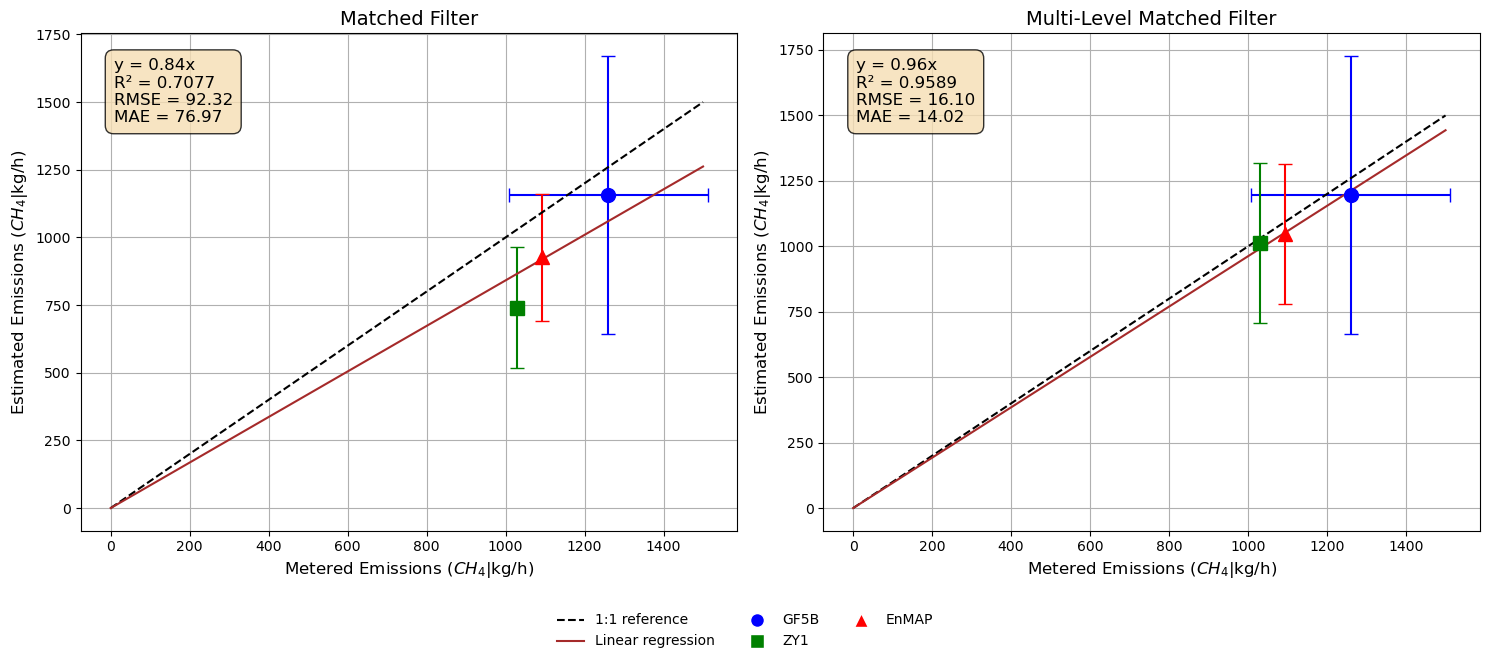

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data
data = {
    'Satellite': ['GF5B', 'ZY1', 'ENMAP'],
    'True Emissions': [1259.71, 1029.785, 1092.52],
    'Matched Filter Estimated Emissions': [1157.3082, 739.8095, 925.9672],
    'Matched Filter Deviation': [513.14606, 223.14218, 235.81036],
    'Multi-Layer Matched Filter Estimated Emissions': [1196.6608, 1013.8201, 1047.6803],
    'Multi-Layer Matched Filter Deviation': [530.59485, 305.7896, 266.8063]
}

df = pd.DataFrame(data)

# Function to perform linear regression with zero intercept
def linear_regression_zero_intercept(x, y):
    model = LinearRegression(fit_intercept=False)
    model.fit(x.reshape(-1, 1), y)
    return model

# Plotting function
def plot_scatter_with_fit(ax, x_vals, y_vals, x_err, y_err, algo_type, color_fit='brown'):
    markers = ['o', 's', '^']
    colors = ['b', 'g', 'r']
    for idx, satellite in enumerate(df['Satellite']):
        ax.errorbar(x_vals[idx], y_vals[idx], xerr=x_err[idx], yerr=y_err[idx], 
                    fmt=markers[idx], color=colors[idx], capsize=5, markersize=10)

    # 1:1 reference line
    ax.plot([0, 1500], [0, 1500], color='k', linestyle='--', label="1:1 reference")
    
    # Linear regression (zero intercept)
    model = linear_regression_zero_intercept(np.array(x_vals), np.array(y_vals))
    slope = model.coef_[0]
    x_fit_range = np.linspace(0, 1500, 100)
    predictions = model.predict(x_fit_range.reshape(-1, 1))
    ax.plot(x_fit_range, predictions, color=color_fit, linestyle='-', label=f'Linear regression: y={slope:.2f}x')
    
    # Add statistical metrics
    r2 = r2_score(y_vals, model.predict(np.array(x_vals).reshape(-1, 1)))
    rmse = np.sqrt(mean_squared_error(y_vals, model.predict(np.array(x_vals).reshape(-1, 1))))
    mae = mean_absolute_error(y_vals, model.predict(np.array(x_vals).reshape(-1, 1)))
    textstr = f'y = {slope:.2f}x\nR² = {r2:.4f}\nRMSE = {rmse:.2f}\nMAE = {mae:.2f}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='wheat', alpha=0.8))

    # Add labels, title, and grid
    ax.set_xlabel(r'Metered Emissions ($CH_4$|kg/h)', fontsize=12)
    ax.set_ylabel(r'Estimated Emissions ($CH_4$|kg/h)', fontsize=12)
    ax.set_title(f'{algo_type}', fontsize=14)
    ax.grid()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Extract values for plotting
true_emissions = df['True Emissions'].values
matched_filter_emissions = df['Matched Filter Estimated Emissions'].values
multi_layer_emissions = df['Multi-Layer Matched Filter Estimated Emissions'].values
matched_deviation = df['Matched Filter Deviation'].values
multi_layer_deviation = df['Multi-Layer Matched Filter Deviation'].values

# Define x error bars (only for GF5B, 20% of true emissions)
x_err = [0.2 * true_emissions[0], 0, 0]

# Plot matched filter algorithm
plot_scatter_with_fit(axs[0], true_emissions, matched_filter_emissions, x_err, matched_deviation, 'Matched Filter')

# Plot multi-layer matched filter algorithm
plot_scatter_with_fit(axs[1], true_emissions, multi_layer_emissions, x_err, multi_layer_deviation, 'Multi-Level Matched Filter')

# Add shared legend in the center
legend_elements = [
    Line2D([0], [0], color='k', linestyle='--', label='1:1 reference'),
    Line2D([0], [0], color='brown', linestyle='-', label='Linear regression'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='GF5B'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='g', markersize=10, label='ZY1'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='r', markersize=10, label='EnMAP'),
    # Line2D([0], [0], color='k', linestyle='--', label='1:1 reference'),
    # Line2D([0], [0], color='brown', linestyle='-', label='Linear regression')
]

# Adjust legend placement
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.01), fontsize=10, ncol=3, frameon=True)


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space at the bottom for the legend
plt.savefig("controlled_release.pdf",bbox_inches="tight")
plt.show()
